In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_9de44eedff024797b6ae7fb37d9e5488 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='6OgcoWncKSYHohDUvoqpeqZ26i87ZXamj7SaduwPAvNG',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_9de44eedff024797b6ae7fb37d9e5488.get_object(Bucket='customersegmentation-donotdelete-pr-tyzbjldpxzuvvk',Key='Online Retail.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

ret = pd.read_excel(body)


In [2]:
ret.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
ret.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [5]:
ret.shape

(541909, 8)

In [8]:
ret.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [9]:
ret.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [10]:
ret.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [11]:
ret = ret[pd.notnull(ret['CustomerID'])]       #dropping records without CustomerID

In [12]:
#Regional customer Distribution
region_cust = ret[['CustomerID', 'Country']].drop_duplicates()
region_cust.groupby(['Country',])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending = False)

,Country,CustomerID
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


In [13]:
ret['sales'] = ret['Quantity']*ret['UnitPrice']         #Calculate total sales from the Quantity and UnitPrice

In [22]:
ret = ret.loc[ret['InvoiceDate'] < '2011-12-01']                        #Drop incomplete month

ret = ret.loc[ret['Quantity'] > 0]                                      #Drop cancelled orders

each_cust = ret.groupby('CustomerID').agg({'sales': sum, 'InvoiceNo': lambda x: x.nunique()})     #use groupby to aggregate sales by CustomerID

each_cust.columns = ['TotalSales', 'OrderCount']     

each_cust['AvgOrderValue'] = each_cust['TotalSales']/each_cust['OrderCount']    #creating a new column 'AvgOrderValue'

In [23]:
each_cust.head()

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.600000
12347.0,4085.18,6,680.863333
12348.0,1797.24,4,449.310000
12349.0,1757.55,1,1757.550000
12350.0,334.40,1,334.400000


In [24]:
each_cust.sort_values('CustomerID', inplace = True)
each_cust.head()

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.600000
12347.0,4085.18,6,680.863333
12348.0,1797.24,4,449.310000
12349.0,1757.55,1,1757.550000
12350.0,334.40,1,334.400000


In [27]:
rank_cust = each_cust.rank(method = 'first')
norm_data = (rank_cust - rank_cust.mean())/rank_cust.std()         #normalizing the data 
norm_data.head(10)

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,1.724999,-1.731446,1.731446
12347.0,1.457445,1.064173,1.401033
12348.0,0.967466,0.573388,0.929590
12349.0,0.944096,-1.730641,1.683093
12350.0,-0.732148,-1.729835,0.331622
12352.0,1.193114,1.309162,0.169639
12353.0,-1.636352,-1.729029,-1.570269
12354.0,0.508917,-1.728223,1.612981
12355.0,-0.386422,-1.727417,0.970690


In [31]:
from sklearn.metrics import silhouette_score                    # Use silhouette coefficient to determine the best number of clusters

for n_cluster in [4,5,6,7]:
    kmeans = KMeans(n_clusters=n_cluster).fit(
        norm_data[['TotalSales', 'OrderCount', 'AvgOrderValue']])
    
    silhouette_avg = silhouette_score(
        norm_data[['TotalSales', 'OrderCount', 'AvgOrderValue']], 
        kmeans.labels_)
    
    print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))

Silhouette Score for 4 Clusters: 0.4115
Silhouette Score for 5 Clusters: 0.3777
Silhouette Score for 6 Clusters: 0.3780
Silhouette Score for 7 Clusters: 0.3913


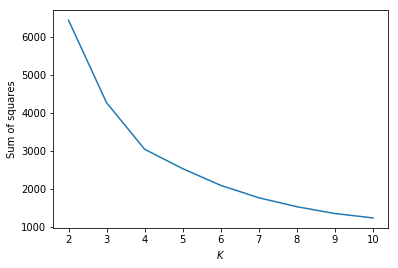

In [43]:
from sklearn import cluster
import numpy as np

SSE = []

krange = list(range(2,11))
X = norm_data[['TotalSales','OrderCount','AvgOrderValue']].values

for n in krange:
    model = cluster.KMeans(n_clusters=n, random_state = 3)
    model.fit_predict(X)
    cluster_assignments = model.labels_
    centers = model.cluster_centers_
    SSE.append(np.sum((X - centers[cluster_assignments]) ** 2))
    
plt.plot(krange, SSE)
plt.xlabel('$K$')
plt.ylabel('Sum of squares')
plt.show()


In [45]:
kmeans = KMeans(n_clusters = 4).fit(norm_data[['TotalSales', 'OrderCount', 'AvgOrderValue']])

four_cluster = norm_data[['TotalSales', 'OrderCount', 'AvgOrderValue']].copy(deep=True)
four_cluster['Cluster'] = kmeans.labels_

In [46]:
four_cluster.head(10)

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,1.724999,-1.731446,1.731446,2
12347.0,1.457445,1.064173,1.401033,1
12348.0,0.967466,0.573388,0.929590,1
12349.0,0.944096,-1.730641,1.683093,2
12350.0,-0.732148,-1.729835,0.331622,2
12352.0,1.193114,1.309162,0.169639,1
12353.0,-1.636352,-1.729029,-1.570269,3
12354.0,0.508917,-1.728223,1.612981,2
12355.0,-0.386422,-1.727417,0.970690,2


In [49]:
cluster1_metrics = kmeans.cluster_centers_[0]
cluster2_metrics = kmeans.cluster_centers_[1]
cluster3_metrics = kmeans.cluster_centers_[2]
cluster4_metrics = kmeans.cluster_centers_[3]

data = [cluster1_metrics, cluster2_metrics, cluster3_metrics, cluster4_metrics]
cluster_center = pd.DataFrame(data)

In [50]:
cluster_center.columns = four_cluster.columns[0:3]
cluster_center

,TotalSales,OrderCount,AvgOrderValue
0,0.217948,0.715536,-0.643378
1,1.206306,1.005522,0.868374
2,-0.132577,-0.849218,0.798219
3,-1.246459,-0.797727,-1.061066


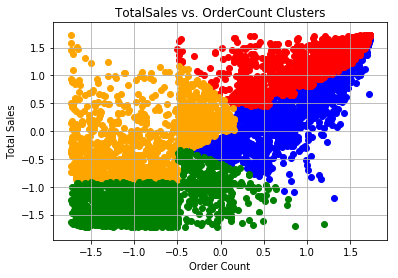

In [55]:
plt.scatter(
four_cluster.loc[four_cluster['Cluster'] == 0]['OrderCount'], 
four_cluster.loc[four_cluster['Cluster'] == 0]['TotalSales'],
c='blue')

plt.scatter(
four_cluster.loc[four_cluster['Cluster'] == 1]['OrderCount'], 
four_cluster.loc[four_cluster['Cluster'] == 1]['TotalSales'],
c='red')

plt.scatter(
four_cluster.loc[four_cluster['Cluster'] == 2]['OrderCount'], 
four_cluster.loc[four_cluster['Cluster'] == 2]['TotalSales'],
c='orange')

plt.scatter(
four_cluster.loc[four_cluster['Cluster'] == 3]['OrderCount'], 
four_cluster.loc[four_cluster['Cluster'] == 3]['TotalSales'],
c='green')

plt.title('TotalSales vs. OrderCount Clusters')
plt.xlabel('Order Count')
plt.ylabel('Total Sales')
plt.grid()
plt.show()



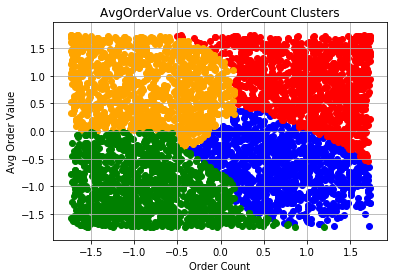

In [56]:
plt.scatter(
four_cluster.loc[four_cluster['Cluster'] == 0]['OrderCount'], 
four_cluster.loc[four_cluster['Cluster'] == 0]['AvgOrderValue'],
c='blue')

plt.scatter(
four_cluster.loc[four_cluster['Cluster'] == 1]['OrderCount'], 
four_cluster.loc[four_cluster['Cluster'] == 1]['AvgOrderValue'],
c='red')

plt.scatter(
four_cluster.loc[four_cluster['Cluster'] == 2]['OrderCount'], 
four_cluster.loc[four_cluster['Cluster'] == 2]['AvgOrderValue'],
c='orange')

plt.scatter(
four_cluster.loc[four_cluster['Cluster'] == 3]['OrderCount'], 
four_cluster.loc[four_cluster['Cluster'] == 3]['AvgOrderValue'],
c='green')

plt.title('AvgOrderValue vs. OrderCount Clusters')
plt.xlabel('Order Count')
plt.ylabel('Avg Order Value')
plt.grid()
plt.show()



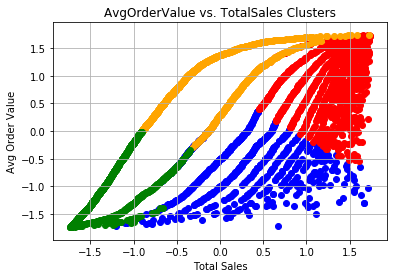

In [58]:
plt.scatter(
four_cluster.loc[four_cluster['Cluster'] == 0]['TotalSales'], 
four_cluster.loc[four_cluster['Cluster'] == 0]['AvgOrderValue'],
c='blue')

plt.scatter(
four_cluster.loc[four_cluster['Cluster'] == 1]['TotalSales'], 
four_cluster.loc[four_cluster['Cluster'] == 1]['AvgOrderValue'],
c='red')

plt.scatter(
four_cluster.loc[four_cluster['Cluster'] == 2]['TotalSales'], 
four_cluster.loc[four_cluster['Cluster'] == 2]['AvgOrderValue'],
c='orange')

plt.scatter(
four_cluster.loc[four_cluster['Cluster'] == 3]['TotalSales'], 
four_cluster.loc[four_cluster['Cluster'] == 3]['AvgOrderValue'],
c='green')

plt.title('AvgOrderValue vs. TotalSales Clusters')
plt.xlabel('Total Sales')
plt.ylabel('Avg Order Value')
plt.grid()
plt.show()

In [65]:
high_value_cluster = four_cluster.loc[four_cluster['Cluster'] == 2]
pd.DataFrame(ret.loc[ret['CustomerID'].isin(high_value_cluster.index)].groupby('Description').count()['StockCode'].sort_values(ascending=False).head())

,StockCode
Description,
REGENCY CAKESTAND 3 TIER,201
WHITE HANGING HEART T-LIGHT HOLDER,157
ASSORTED COLOUR BIRD ORNAMENT,155
SET OF 3 CAKE TINS PANTRY DESIGN,151
PARTY BUNTING,137
